# Notebook: fine-tune SAM (segment anything) on a custom dataset

In this notebook, we'll reproduce the [MedSAM](https://github.com/bowang-lab/MedSAM) project, which fine-tunes [SAM](https://huggingface.co/docs/transformers/main/en/model_doc/sam) on a dataset of medical images. For demo purposes, we'll use a toy dataset, but this can easily be scaled up.

Resources used to create this notebook (thanks 🙏):
* [Encode blog post](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
* [MedSAM repository](https://github.com/bowang-lab/MedSAM).

## Set-up environment

We first install 🤗 Transformers and 🤗 Datasets.

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [3]:
!pip install -q datasets

We also install the [Monai](https://github.com/Project-MONAI/MONAI) repository as we'll use a custom loss function from it.

In [4]:
!pip install -q monai

In [5]:
!pip install patchify


## Load dataset

Here we load a small dataset of 130 (image, ground truth mask) pairs.

To load your own images and masks, refer to the bottom of my [SAM inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Run_inference_with_MedSAM_using_HuggingFace_Transformers.ipynb).

See also [this guide](https://huggingface.co/docs/datasets/image_dataset).

In [6]:

import numpy as np
import matplotlib.pyplot as plt
# import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage


In [7]:
from datasets import load_dataset

dataset = load_dataset("scene_parse_150", split="train[:100]")


The repository for scene_parse_150 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scene_parse_150.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [85]:
dataset

Dataset({
    features: ['image', 'annotation', 'scene_category'],
    num_rows: 100
})

We can visualize an example:

In [9]:
def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [102, 255, 255],
      [54, 67, 235],
      [220, 220, 0],
      [182, 182, 255],
      [0, 255, 255],
      [5, 0, 255],
      [183, 130, 88],
      [204, 170, 102],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 204],
      [170, 153, 87],
      [7, 188, 255],
      [190, 190, 190],
      [255, 153, 153],
      [180, 165, 180],
      [119, 11, 32],
      [153, 153, 153],
      [150, 120, 90],
      [63, 128, 67],
      [0, 0, 230],
      [0, 0, 70],
      [0, 128, 192],
  ])



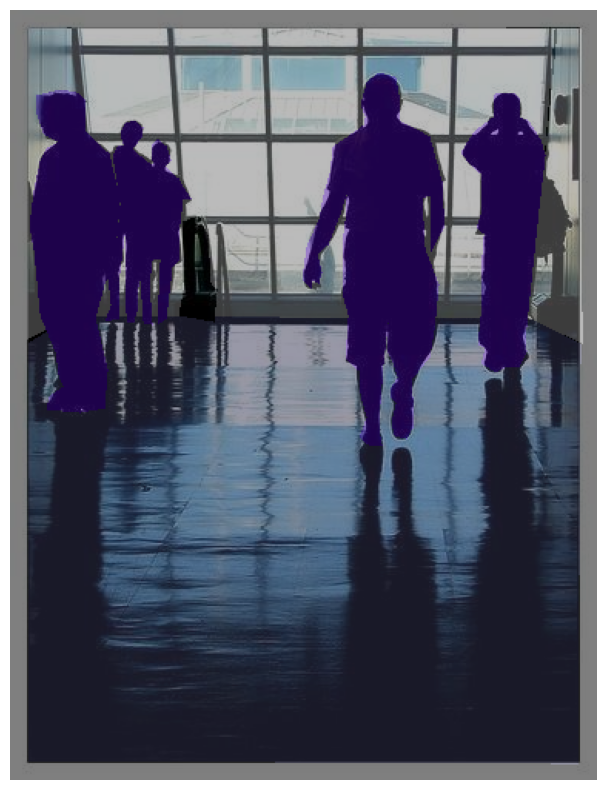

In [10]:
import matplotlib.pyplot as plt

def visualize_seg_mask(image: np.ndarray, mask: np.ndarray):
   color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
   palette = np.array(create_ade20k_label_colormap())
   for label, color in enumerate(palette):
       color_seg[mask == label, :] = color
   color_seg = color_seg[..., ::-1]  # convert to BGR

   img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
   img = img.astype(np.uint8)

   plt.figure(figsize=(15, 10))
   plt.imshow(img)
   plt.axis("off")
   plt.show()


visualize_seg_mask(
    np.array(dataset[0]["image"]),
    np.array(dataset[0]["annotation"])
)

In [11]:
import albumentations

transform = albumentations.Compose(
    [
        albumentations.Resize(1024, 1024),
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ]
)

In [12]:
def transforms(examples):
    transformed_images, transformed_masks = [], []
    for image, seg_mask in zip(examples["image"], examples["annotation"]):
        image, seg_mask = np.array(image), np.array(seg_mask)
        transformed = transform(image=image, mask=seg_mask)
        transformed_images.append(transformed["image"])
        transformed_masks.append(transformed["mask"])
    examples["image"] = transformed_images
    examples["annotation"] = transformed_masks
    return examples
dataset.set_transform(transforms)

In [13]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [14]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch

# ... (rest of your code) ...

def collate_fn(batch):
    """Custom collate function to handle PIL images and annotations."""
    # Convert PIL images to tensors
    images = [ToTensor()(item['image']) for item in batch]

    # Stack images into a batch tensor
    images = torch.stack(images, dim=0)

    # Assuming 'annotation' is a PIL Image, convert to tensor and stack
    annotations = [ToTensor()(item['annotation']) for item in batch]
    annotations = torch.stack(annotations, dim=0)

    # Create a new batch dictionary
    new_batch = {'image': images, 'annotation': annotations}

    # Add other items to the batch if needed (excluding 'image' and 'annotation')
    for key in batch[0]:
        if key not in ['image', 'annotation']:
            new_batch[key] = [item[key] for item in batch]

    return new_batch

train_dataloader = DataLoader(dataset, batch_size=2, shuffle=True,collate_fn=collate_fn)

In [15]:
from transformers import SamModel
from torch.optim import Adam
import monai
import torch
from tqdm import tqdm
from statistics import mean
from torchvision import transforms

# Load the SAM model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze the vision encoder and prompt encoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

# Set up optimizer and loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Set up device and model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Define a transform to resize images to 1024x1024
resize_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
])

# Fine-tune the model
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # Resize the images to 1024x1024
        resized_images = resize_transform(batch["image"])

        # Forward pass
        outputs = model(pixel_values=resized_images.to(device),
                        input_boxes=None,  # Assuming no bounding boxes provided
                        multimask_output=False)

        # Predicted masks
        predicted_masks = outputs.pred_masks.squeeze(1)

        # Ground truth masks (resize as well if needed)
        ground_truth_masks = batch["annotation"].float().to(device)
        # ground_truth_masks_resized = resize_transform(ground_truth_masks)
        predicted_masks = resize_transform(predicted_masks)

        # Compute loss
        loss = seg_loss(predicted_masks, ground_truth_masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


EPOCH: 0
Mean loss: 0.9238098561763763


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


EPOCH: 1
Mean loss: 0.7186616748571396


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


EPOCH: 2
Mean loss: 0.6622898358106614


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


EPOCH: 3
Mean loss: 0.6356404948234559


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


EPOCH: 4
Mean loss: 0.6070236307382584


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


EPOCH: 5
Mean loss: 0.6041218626499176


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


EPOCH: 6
Mean loss: 0.5773296070098877


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


EPOCH: 7
Mean loss: 0.5697115725278854


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


EPOCH: 8
Mean loss: 0.566966101527214


100%|██████████| 50/50 [00:25<00:00,  1.92it/s]

EPOCH: 9
Mean loss: 0.5608916264772416


## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

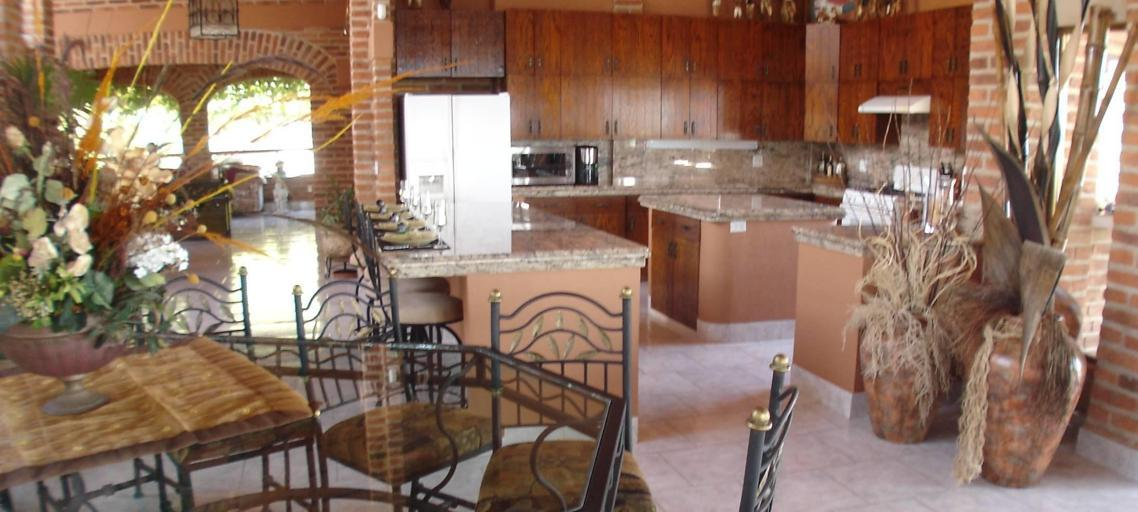

In [88]:
dataset_test = load_dataset("scene_parse_150", split="test[:100]")
dataset_test[0]['image']

In [114]:
import albumentations

transform = albumentations.Compose(
    [
        albumentations.Resize(1024, 1024),
#         albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        
    ]
)
def transforms(examples):
    transformed_images, transformed_masks = [], []
    for image, seg_mask in zip(examples["image"], examples["annotation"]):
        image, seg_mask = np.array(image), np.array(seg_mask)
        transformed = transform(image=image, mask=seg_mask)
        transformed_images.append(transformed["image"])
        transformed_masks.append(transformed["mask"])
    examples["image"] = transformed_images
    examples["annotation"] = transformed_masks
    return examples
dataset_test.set_transform(transforms)
dataset_test

Dataset({
    features: ['image', 'annotation', 'scene_category'],
    num_rows: 100
})

In [115]:
test_dataloader = DataLoader(dataset_test, batch_size=2, shuffle=True,collate_fn=collate_fn)

In [120]:
batch["image"].shape

torch.Size([2, 3, 1024, 1024])

  0%|          | 0/50 [00:00<?, ?it/s]

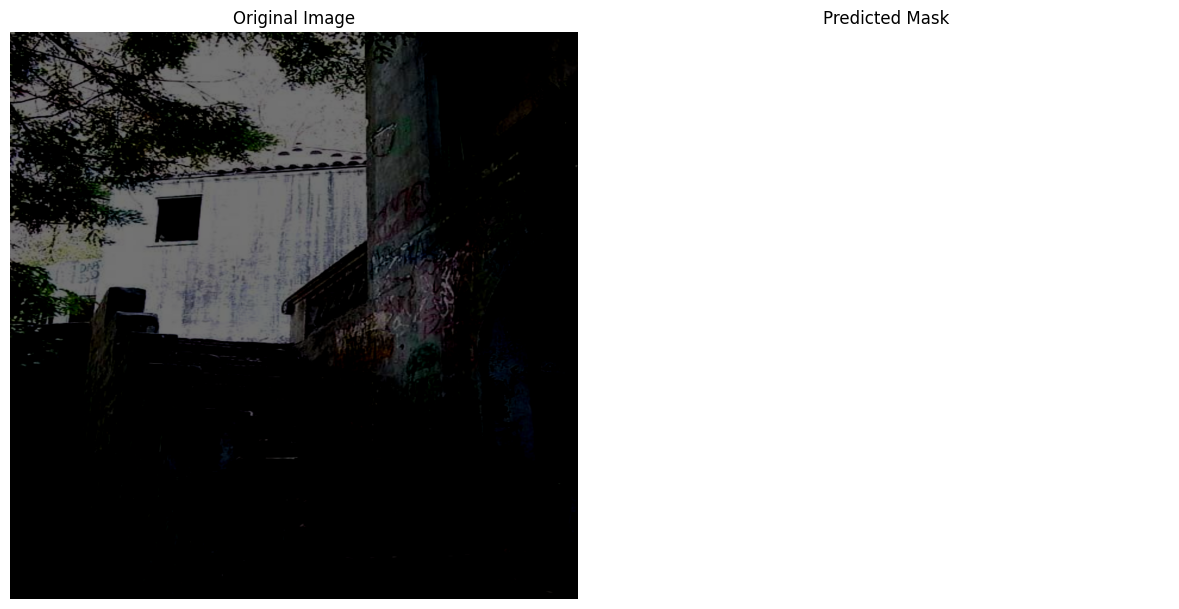

  0%|          | 0/50 [00:01<?, ?it/s]


In [136]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

def show_mask(mask, ax, random_color=False): 
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]  # Get the height and width of the mask
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)  # Reshape mask and apply color
    ax.imshow(mask_image)

# Function for inference
def run_inference_and_visualize(train_dataloader, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients during inference
        for batch in tqdm(train_dataloader):
            # Forward pass
            outputs = model(pixel_values=batch["image"].to(device),
                            input_boxes=None,  # Assuming no bounding boxes provided
                            multimask_output=False)

            # Predicted masks
            predicted_masks = outputs.pred_masks.squeeze(1)

            # Create a figure for visualization
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Two subplots: one for the image and one for the mask

            # Visualize the first image in the batch
            original_image = batch["image"][0].cpu().permute(1, 2, 0).numpy()  # Change the shape to (H, W, C)
            axes[0].imshow(original_image)  # Display the original image
            axes[0].set_title("Original Image")
            axes[0].axis("off")  # Hide axes

            # Visualize the predicted mask
            show_mask(predicted_masks[0].cpu().numpy(), axes[1])  # Move to CPU for visualization if necessary
            axes[1].set_title("Predicted Mask")
            axes[1].axis("off")  # Hide axes

            # Display the results
            plt.tight_layout()
            plt.show()
            
            break  # Only visualize the first batch, remove if you want to see more

# Run inference on the test dataloader and visualize the predictions
run_inference_and_visualize(train_dataloader, model)
